In [1]:
from __future__ import absolute_import, print_function

import argparse, json, os, requests, sys, time
from io import BytesIO
from os.path import join, isfile
from PIL import Image

from mxnet.gluon.model_zoo import vision
import numpy as np
from matplotlib import pyplot as plt

import tvm
from tvm import te
from tvm import rpc, autotvm, relay
from tvm.contrib import graph_runtime, utils, download
from tvm.contrib.debugger import debug_runtime
from tvm.relay import transform

import vta
from vta.testing import simulator
from vta.top import graph_pack

import torch
import torchvision
from tvm.contrib.download import download_testdata



# Make sure that TVM was compiled with RPC=1
assert tvm.runtime.enabled("rpc")

/home/srchand/miniconda3/envs/tvm-build-il/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load VTA parameters from the 3rdparty/vta-hw/config/vta_config.json file
env = vta.get_env()

# Set ``device=arm_cpu`` to run inference on the CPU
# or ``device=vta`` to run inference on the FPGA.
device = "vta"
target = env.target if device == "vta" else env.target_vta_cpu

# Dictionary lookup for when to start/end bit packing
pack_dict = {
    #"resnet18_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet34": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet50": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet101": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "vgg16":    ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet34_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet50_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet101_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
}

# Name of Gluon model to compile
# The ``start_pack`` and ``stop_pack`` labels indicate where
# to start and end the graph packing relay pass: in other words
# where to start and finish offloading to VTA.
#model = "resnet18_v1"
#assert model in pack_dict
model = "resnet18"

In [4]:
remote = None
if env.TARGET not in ["sim", "tsim", "intelfocl"]:

    # Get remote from tracker node if environment variable is set.
    # To set up the tracker, you'll need to follow the "Auto-tuning
    # a convolutional network for VTA" tutorial.
    tracker_host = os.environ.get("TVM_TRACKER_HOST", None)
    tracker_port = os.environ.get("TVM_TRACKER_PORT", None)
    # Otherwise if you have a device you want to program directly from
    # the host, make sure you've set the variables below to the IP of
    # your board.
#     device_host = os.environ.get("VTA_RPC_HOST", "192.168.2.99")
    device_host="192.168.2.99"
    device_port = os.environ.get("VTA_RPC_PORT", "9091")
    if not tracker_host or not tracker_port:
        remote = rpc.connect(device_host, int(device_port))
    else:
        remote = autotvm.measure.request_remote(
            env.TARGET, tracker_host, int(tracker_port), timeout=10000
        )

    # Reconfigure the JIT runtime and FPGA.
    # You can program the FPGA with your own custom bitstream
    # by passing the path to the bitstream file instead of None.
    reconfig_start = time.time()
    vta.reconfig_runtime(remote)
    #vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/TVM_IL/tvm/vta/sri_scripts/bitstreams/vta_il_apm.bit")
    vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/bitstreams/vta_trojan.bit")
    #vta.program_fpga(remote, bitstream=None)
    reconfig_time = time.time() - reconfig_start
    print("Reconfigured FPGA and RPC runtime in {0:.2f}s!".format(reconfig_time))

# In simulation mode, host the RPC server locally.
else:
    remote = rpc.LocalSession()

    if env.TARGET in ["intelfocl"]:
        # program intelfocl aocx
        vta.program_fpga(remote, bitstream="vta.bitstream")

# Get execution context from remote
ctx = remote.ext_dev(0) if device == "vta" else remote.cpu(0)

Reconfigured FPGA and RPC runtime in 3.09s!


In [5]:
# Load pre-configured AutoTVM schedules
with autotvm.tophub.context(target):
    
    input_name = "input0"

    # Populate the shape and data type dictionary for ImageNet classifier input
    dtype_dict = {input_name: "float32"}
    shape_dict = {input_name: (env.BATCH, 3, 224, 224)}


    # Get off the shelf gluon model, and convert to relay
    #gluon_model = vision.get_model("resnet18_v2", pretrained=True)
    
    
    pytorch_model = getattr(torchvision.models, model)(pretrained=True)
    
        
    input_shape = [1, 3, 224, 224]
    input_data = torch.randn(input_shape)
    scripted_model = torch.jit.trace(pytorch_model, input_data).eval()
    
    shape_list = [(input_name, input_shape)]


    # Measure build start time
    build_start = time.time()

    # Start front end compilation
    mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)
    
    
    #mod, params = relay.frontend.from_mxnet(gluon_model, shape_dict)

    #mod, params = relay.frontend.from_mxnet(net, shape_dict)
    
    # Update shape and type dictionary
    shape_dict.update({k: v.shape for k, v in params.items()})
    dtype_dict.update({k: str(v.dtype) for k, v in params.items()})

    if target.device_name == "vta":
        # Perform quantization in Relay
        # Note: We set opt_level to 3 in order to fold batch norm
        with tvm.transform.PassContext(opt_level=3):
            with relay.quantize.qconfig(global_scale=8.0, skip_conv_layers=[0]):
                mod = relay.quantize.quantize(mod, params=params)
#                 print(mod.astext(show_meta_data=False))
#                 print(apput)
            # Perform graph packing and constant folding for VTA target
            assert env.BLOCK_IN == env.BLOCK_OUT
            # do device annotation if target is intelfocl or sim
            relay_prog = graph_pack(
                mod["main"],
                env.BATCH,
                env.BLOCK_IN,
                env.BLOCK_OUT,
                env.WGT_WIDTH,
                start_name=pack_dict[model][0],
                stop_name=pack_dict[model][1],

                #start_name="cast",
                #stop_name="reshape",
                #start_name='nn.max_pool2d',
                #stop_name='add',
                #start_name_idx=8,
                #stop_name_idx=227,
                device_annot=(env.TARGET == "intelfocl"),
            )
    else:
        relay_prog = mod["main"]

    # Compile Relay program with AlterOpLayout disabled
    if target.device_name != "vta":
        with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph, lib, params = relay.build(
                relay_prog, target=target, params=params, target_host=env.target_host
            )
    else:
        if env.TARGET == "intelfocl":
            # multiple targets to run both on cpu and vta
            target = {"cpu": env.target_vta_cpu, "ext_dev": target}
        with vta.build_config(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph, lib, params = relay.build(
                relay_prog, target=target, params=params, target_host=env.target_host
            )

    # Measure Relay build time
    build_time = time.time() - build_start
    print(model + " inference graph built in {0:.2f}s!".format(build_time))

    # Send the inference library over to the remote RPC server
    temp = utils.tempdir()
    lib.export_library(temp.relpath("graphlib.tar"))
    remote.upload(temp.relpath("graphlib.tar"))
    lib = remote.load_module("graphlib.tar")

    if env.TARGET == "intelfocl":
        ctxes = [remote.ext_dev(0), remote.cpu(0)]
        m = graph_runtime.create(graph, lib, ctxes)
    else:
        # Graph runtime
        m = graph_runtime.create(graph, lib, ctx)

/home/srchand/miniconda3/envs/tvm-build-il/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/srchand/miniconda3/envs/tvm-build-il/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_55585/531530458.py:82: DeprecationWarning: legacy graph runtime behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_runtime.GraphModule for the  new recommended usage.
  graph, lib, params = relay.build(


resnet18 inference graph built in 13.16s!


In [5]:
print(mod.astext(show_meta_data=False))

#[version = "0.0.5"]
def @main(%input0: Tensor[(1, 3, 224, 224), float32]) -> Tensor[(1, 1000), float32] {
  %0 = nn.conv2d(%input0, meta[relay.Constant][0] /* ty=Tensor[(64, 3, 7, 7), float32] */, strides=[2, 2], padding=[3, 3, 3, 3], channels=64, kernel_size=[7, 7]) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %1 = add(%0, meta[relay.Constant][1] /* ty=Tensor[(64, 1, 1), float32] */) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %2 = nn.relu(%1) /* ty=Tensor[(1, 64, 112, 112), float32] */;
  %3 = nn.max_pool2d(%2, pool_size=[3, 3], strides=[2, 2], padding=[1, 1, 1, 1]) /* ty=Tensor[(1, 64, 56, 56), float32] */;
  %4 = annotation.stop_fusion(%3) /* ty=Tensor[(1, 64, 56, 56), float32] */;
  %5 = multiply(%4, 16f /* ty=float32 */) /* ty=Tensor[(1, 64, 56, 56), float32] */;
  %6 = round(%5) /* ty=Tensor[(1, 64, 56, 56), float32] */;
  %7 = clip(%6, a_min=-127f, a_max=127f) /* ty=Tensor[(1, 64, 56, 56), float32] */;
  %8 = cast(%7, dtype="int8") /* ty=Tensor[(1, 64, 56, 56), int8] */;


File synset.txt exists, skip.


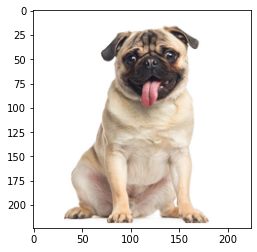

In [6]:
categ_url = "https://github.com/uwsampl/web-data/raw/main/vta/models/"
categ_fn = "synset.txt"
download.download(join(categ_url, categ_fn), categ_fn)
synset = eval(open(categ_fn).read())

# Download test image
image_url = "https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg"
image_fn = "pug.jpg"
#download.download(image_url, image_fn)

# Prepare test image for inference
image = Image.open(image_fn).resize((224, 224))
plt.imshow(image)
plt.show()
image = np.array(image) - np.array([123.0, 117.0, 104.0])
image /= np.array([58.395, 57.12, 57.375])
image = image.transpose((2, 0, 1))
image = image[np.newaxis, :]
image = np.repeat(image, env.BATCH, axis=0)

# Set the network parameters and inputs
m.set_input(**params)
m.set_input(input_name, image)

In [20]:


#p = mp.Process(target=read_apm, args=('bob',))
#t1 = tr.Thread(target=read_apm, args=('bob',))
#pool = mp.Pool(4)
# Download ImageNet categories


# Perform inference and gather execution statistics
# More on: :py:method:`tvm.runtime.Module.time_evaluator`
# num = 3  # number of times we run module for a single measurement
# rep = 2  # number of measurements (we derive std dev from this)


#timer = m.module.time_evaluator("run", ctx, number=num, repeat=rep)


#timer = m.module.time_evaluator("run", ctx, number=num, repeat=rep)
#

if env.TARGET in ["sim", "tsim"]:
    simulator.clear_stats()
    timer()
    sim_stats = simulator.stats()
    print("\nExecution statistics:")
    for k, v in sim_stats.items():
        # Since we execute the workload many times, we need to normalize stats
        # Note that there is always one warm up run
        # Therefore we divide the overall stats by (num * rep + 1)
        print("\t{:<16}: {:>16}".format(k, v // (num * rep + 1)))
else:
    #vta.init_apm(remote)
    #tcost = timer()
    #vta.read_metrics(remote,0)
    m.run()
    #vta.reset_apm(remote)
    #std = np.std(tcost.results) * 1000
    #mean = tcost.mean * 1000
    #print("\nPerformed inference in %.2fms (std = %.2f) for %d samples" % (mean, std, env.BATCH))
    #print("Average per sample inference time: %.2fms" % (mean / env.BATCH))

#print("done")
    # Get classification results
tvm_output = m.get_output(0, tvm.nd.empty((env.BATCH, 1000), "float32", remote.cpu(0)))
for b in range(env.BATCH):
    top_categories = np.argsort(tvm_output.asnumpy()[b])
    # Report top-5 classification results
    print("\n{} prediction for sample {}".format(model, b))
    print("\t#1:", synset[top_categories[-1]])
    print("\t#2:", synset[top_categories[-2]])
    print("\t#3:", synset[top_categories[-3]])
    print("\t#4:", synset[top_categories[-4]])
    print("\t#5:", synset[top_categories[-5]])
    # This just checks that one of the 5 top categories
    # is one variety of cat; this is by no means an accurate
    # assessment of how quantization affects classification
    # accuracy but is meant to catch changes to the
    # quantization pass that would accuracy in the CI.
    cat_detected = False
    for k in top_categories[-5:]:
        if "pug" in synset[k]:
            cat_detected = True
    assert cat_detected


resnet18 prediction for sample 0
	#1: pug, pug-dog
	#2: bull mastiff
	#3: remote control, remote
	#4: dumbbell
	#5: tennis ball


In [2]:
[1,2,3,4,5][:4]

[1, 2, 3, 4]